## LeRobot dataset

Let's load a [LeRobot dataset](https://huggingface.co/datasets/alexis779/so100_ball_cup2) generated via tele-operation.

In [1]:
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata

dataset_id = 'alexis779/so100_ball_cup2'

ds_meta = LeRobotDatasetMetadata(dataset_id)

/home/alexis/Documents/python/robotics/slobot/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The dataset contains `52` episodes.

In [2]:
ds_meta.total_episodes

52

The *Frame Per Second* rate is `30`.

In [3]:
ds_meta.fps

30

Let's select one episode from the dataset.

In [4]:
import torch

episode_index = 0

dataset = LeRobotDataset(dataset_id, episodes=[episode_index])

episode_frame_count = dataset.meta.episodes[episode_index]["length"]

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=episode_frame_count
)

episode = next(iter(dataloader))

The episode duration is ~ 30 sec.

In [5]:
episode_duration = episode_frame_count / ds_meta.fps
episode_duration

29.566666666666666

## Frame content

The main input data for training include
- the camera RGB 640 x 480 image, `observation.images.phone`
- the leader robot state, `action`
- the follower robot state, `observation.state`
- the task description, `task` 

In [6]:
episode

{'observation.images.phone': tensor([[[[0.7569, 0.7490, 0.7333,  ..., 0.6275, 0.6235, 0.6196],
           [0.7569, 0.7490, 0.7333,  ..., 0.6275, 0.6235, 0.6196],
           [0.7529, 0.7490, 0.7373,  ..., 0.6196, 0.6196, 0.6157],
           ...,
           [0.6314, 0.6314, 0.6314,  ..., 0.7608, 0.7216, 0.7216],
           [0.6314, 0.6314, 0.6314,  ..., 0.7059, 0.6314, 0.6275],
           [0.6314, 0.6314, 0.6314,  ..., 0.7059, 0.6314, 0.6314]],
 
          [[0.6235, 0.6157, 0.6000,  ..., 0.4863, 0.4824, 0.4784],
           [0.6235, 0.6157, 0.6000,  ..., 0.4863, 0.4824, 0.4784],
           [0.6196, 0.6157, 0.6039,  ..., 0.4784, 0.4784, 0.4745],
           ...,
           [0.4588, 0.4588, 0.4588,  ..., 0.9529, 0.9686, 0.9686],
           [0.4588, 0.4588, 0.4588,  ..., 0.9843, 1.0000, 1.0000],
           [0.4588, 0.4588, 0.4588,  ..., 0.9843, 1.0000, 1.0000]],
 
          [[0.4980, 0.4902, 0.4745,  ..., 0.3647, 0.3608, 0.3569],
           [0.4980, 0.4902, 0.4745,  ..., 0.3647, 0.3608, 0.356

In [7]:
start_idx = dataset.meta.episodes[episode_index]["dataset_from_index"]
frame = dataset[start_idx]
frame

{'observation.images.phone': tensor([[[0.7569, 0.7490, 0.7333,  ..., 0.6275, 0.6235, 0.6196],
          [0.7569, 0.7490, 0.7333,  ..., 0.6275, 0.6235, 0.6196],
          [0.7529, 0.7490, 0.7373,  ..., 0.6196, 0.6196, 0.6157],
          ...,
          [0.6314, 0.6314, 0.6314,  ..., 0.7608, 0.7216, 0.7216],
          [0.6314, 0.6314, 0.6314,  ..., 0.7059, 0.6314, 0.6275],
          [0.6314, 0.6314, 0.6314,  ..., 0.7059, 0.6314, 0.6314]],
 
         [[0.6235, 0.6157, 0.6000,  ..., 0.4863, 0.4824, 0.4784],
          [0.6235, 0.6157, 0.6000,  ..., 0.4863, 0.4824, 0.4784],
          [0.6196, 0.6157, 0.6039,  ..., 0.4784, 0.4784, 0.4745],
          ...,
          [0.4588, 0.4588, 0.4588,  ..., 0.9529, 0.9686, 0.9686],
          [0.4588, 0.4588, 0.4588,  ..., 0.9843, 1.0000, 1.0000],
          [0.4588, 0.4588, 0.4588,  ..., 0.9843, 1.0000, 1.0000]],
 
         [[0.4980, 0.4902, 0.4745,  ..., 0.3647, 0.3608, 0.3569],
          [0.4980, 0.4902, 0.4745,  ..., 0.3647, 0.3608, 0.3569],
          [0

In [8]:
import matplotlib.pyplot as plt

dof = 6
joint_names = ["shoulder_pan", "shoulder_lift", "elbow_flex", "wrist_flex", "wrist_roll", "gripper"]

def robot_joint_distribution(robot_type, robot_state):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for joint_id in range(dof):
        axes[joint_id].hist(robot_state[:, joint_id], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[joint_id].set_title(f'{joint_names[joint_id]}')

    plt.suptitle(f"{robot_type} Joint Position Distribution")
    plt.show()


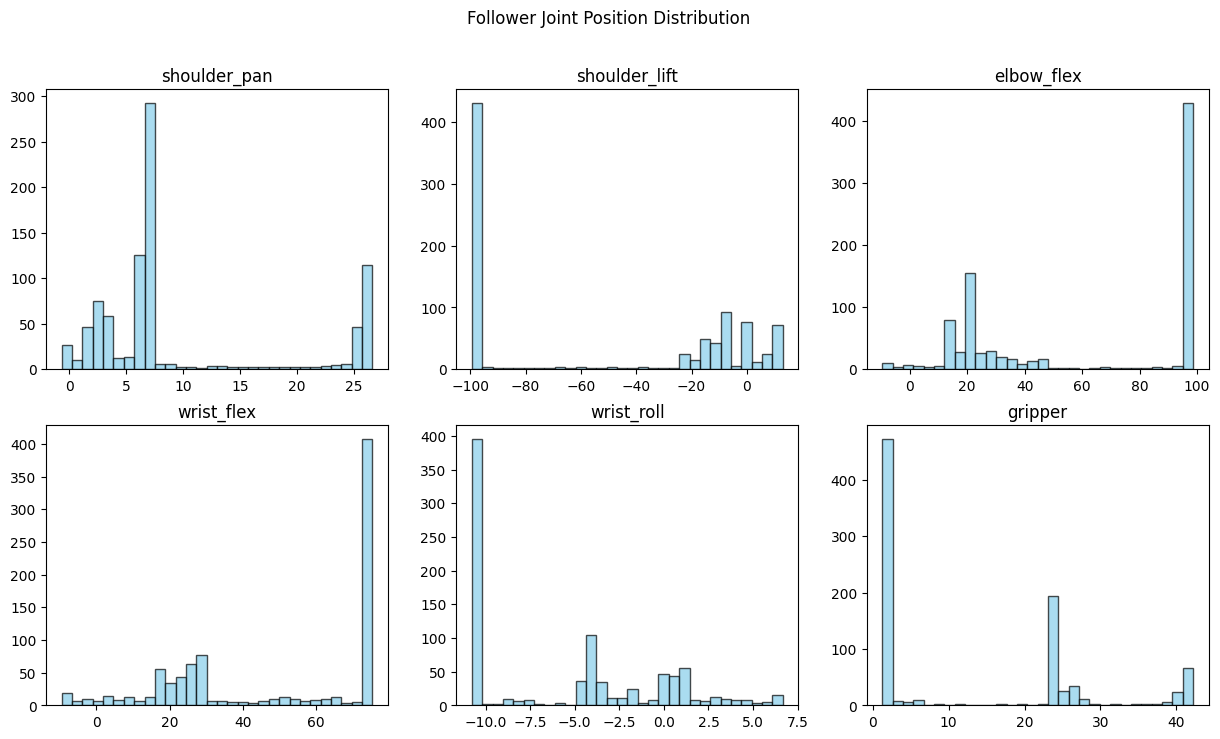

In [9]:
robot_joint_distribution("Follower", episode['observation.state'])

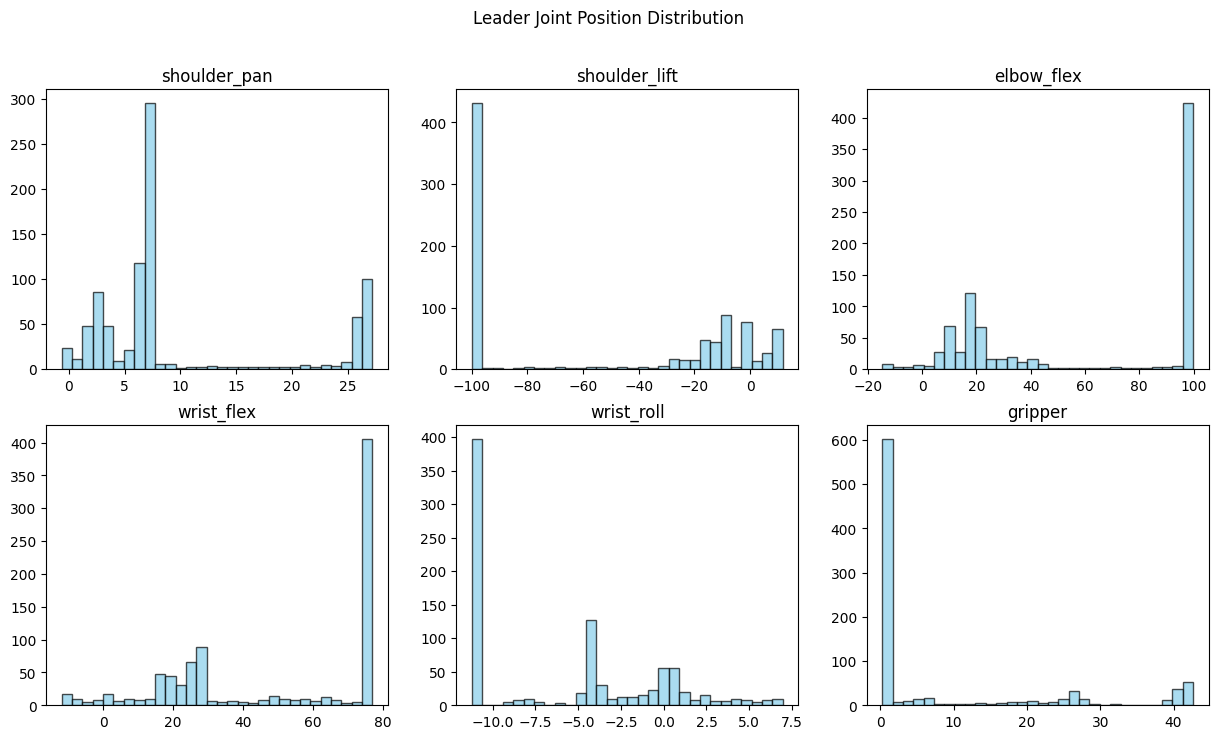

In [10]:
robot_joint_distribution("Leader", episode['action'])

## Leader controls Follower

During teleoperation, for every frame, the leader arm state, read as `action`, is sent as the control command to the follower arm.

The follower arm state, read as `observation.state`, does not reflect the goal position until a few frames.

In [11]:
frame_ids = episode['frame_index'].cpu()
follower = episode['observation.state'].cpu()
leader = episode['action'].cpu()

delay_frames = 4

truncated_leader = leader[:-delay_frames]
truncated_frame_ids = frame_ids[delay_frames:]

truncated_follower = follower[delay_frames:]

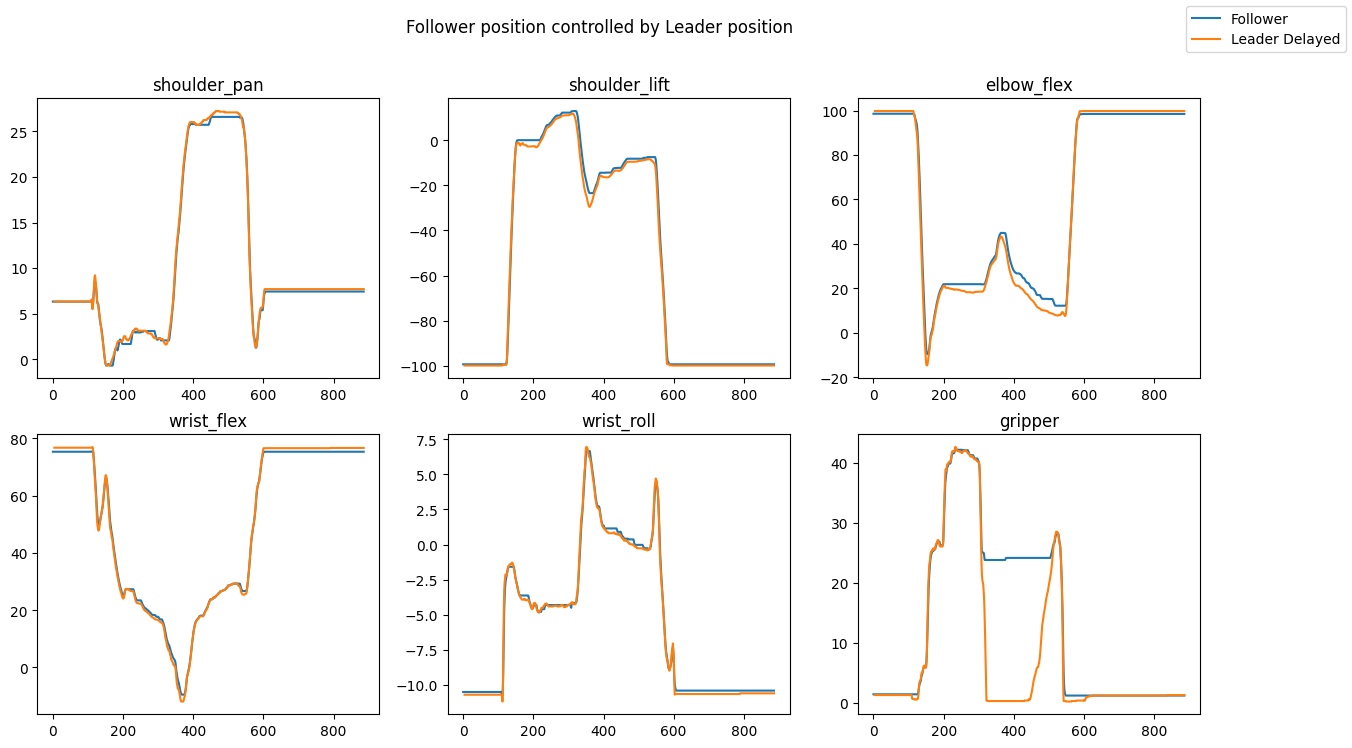

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for joint_id in range(dof):
    axes[joint_id].plot(frame_ids, follower[:, joint_id], label='Follower')
    axes[joint_id].plot(truncated_frame_ids, truncated_leader[:, joint_id], label='Leader Delayed')
    axes[joint_id].set_title(f'{joint_names[joint_id]}')

fig.legend(['Follower', 'Leader Delayed'])

plt.suptitle(f"Follower position controlled by Leader position")
plt.show()

In [13]:
from slobot.feetech import Feetech

feetech = Feetech(connect=False)

rows = [
    torch.tensor(feetech.sim_positions(row))
    for row in follower
]

q = torch.stack(rows)

### Angular Position

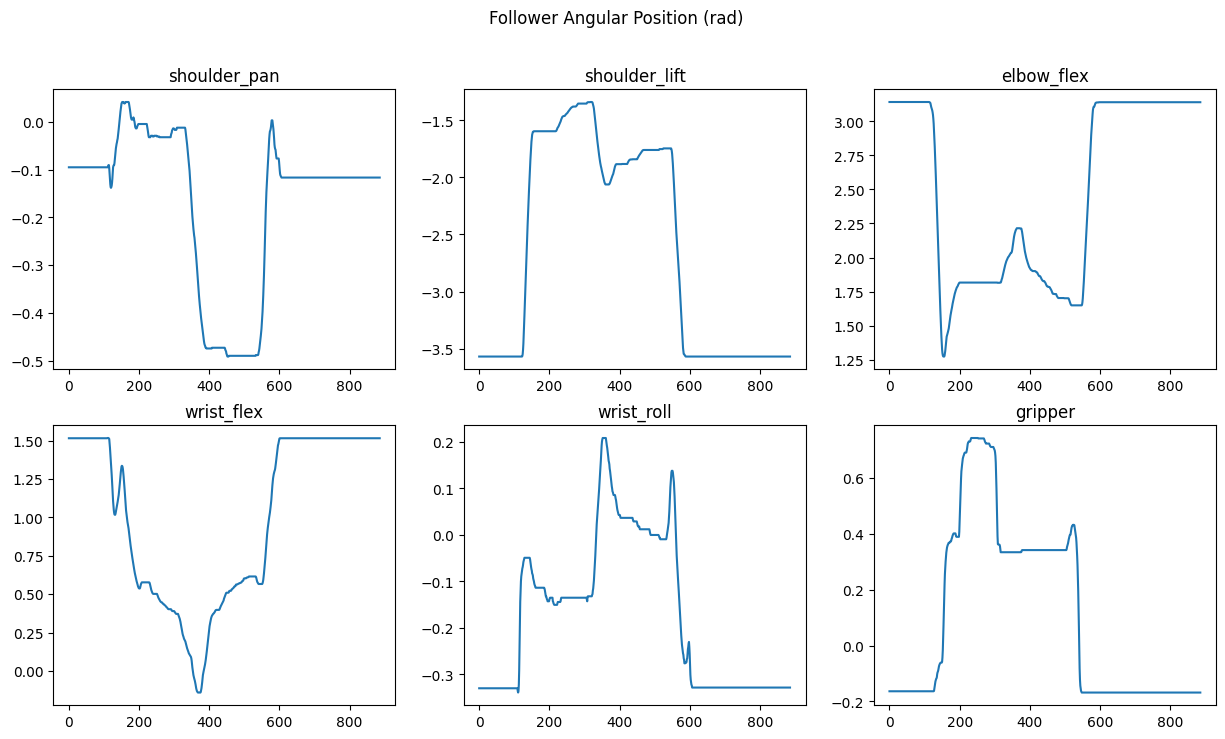

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for joint_id in range(dof):
    axes[joint_id].plot(frame_ids, q[:, joint_id], label='Follower')
    axes[joint_id].set_title(f'{joint_names[joint_id]}')

plt.suptitle(f"Follower Angular Position (rad)")
plt.show()

### Angular Velocity

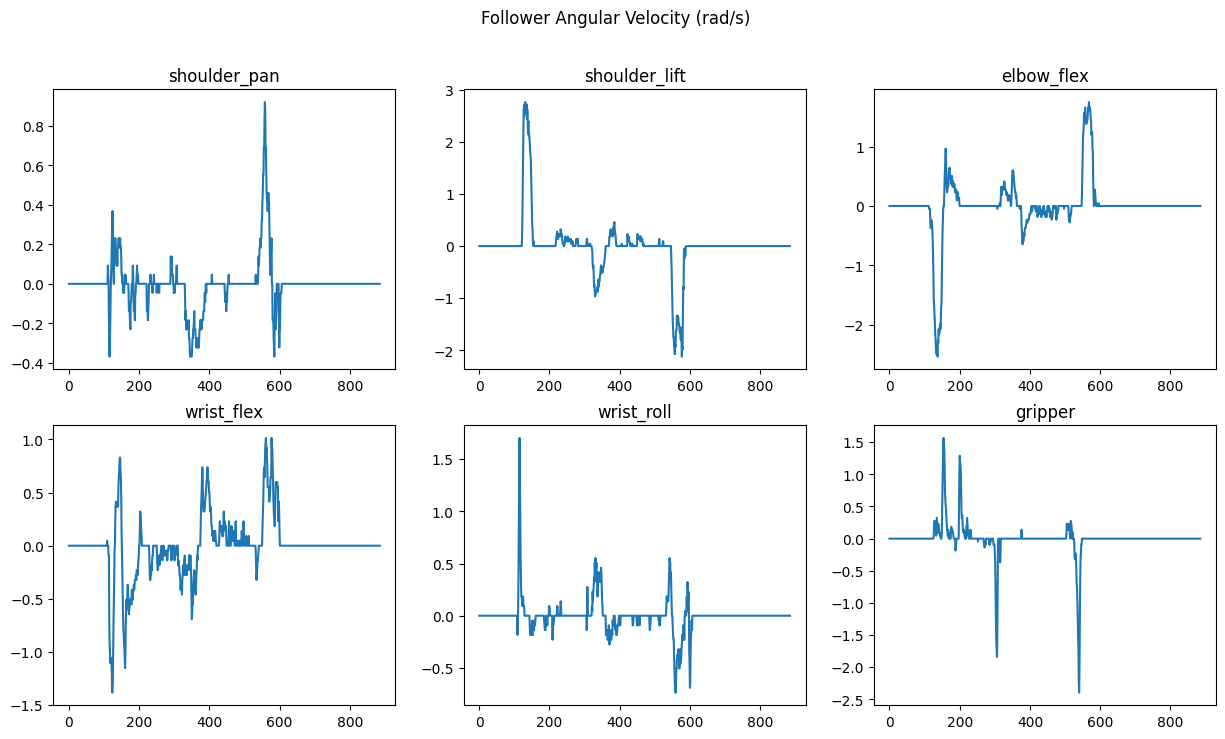

In [15]:
q_dot = (q[1:] - q[:-1]) * ds_meta.fps

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for joint_id in range(dof):
    axes[joint_id].plot(frame_ids[:-1], q_dot[:, joint_id], label='Follower')
    axes[joint_id].set_title(f'{joint_names[joint_id]}')

plt.suptitle(f"Follower Angular Velocity (rad/s)")
plt.show()

### Angular Acceleration

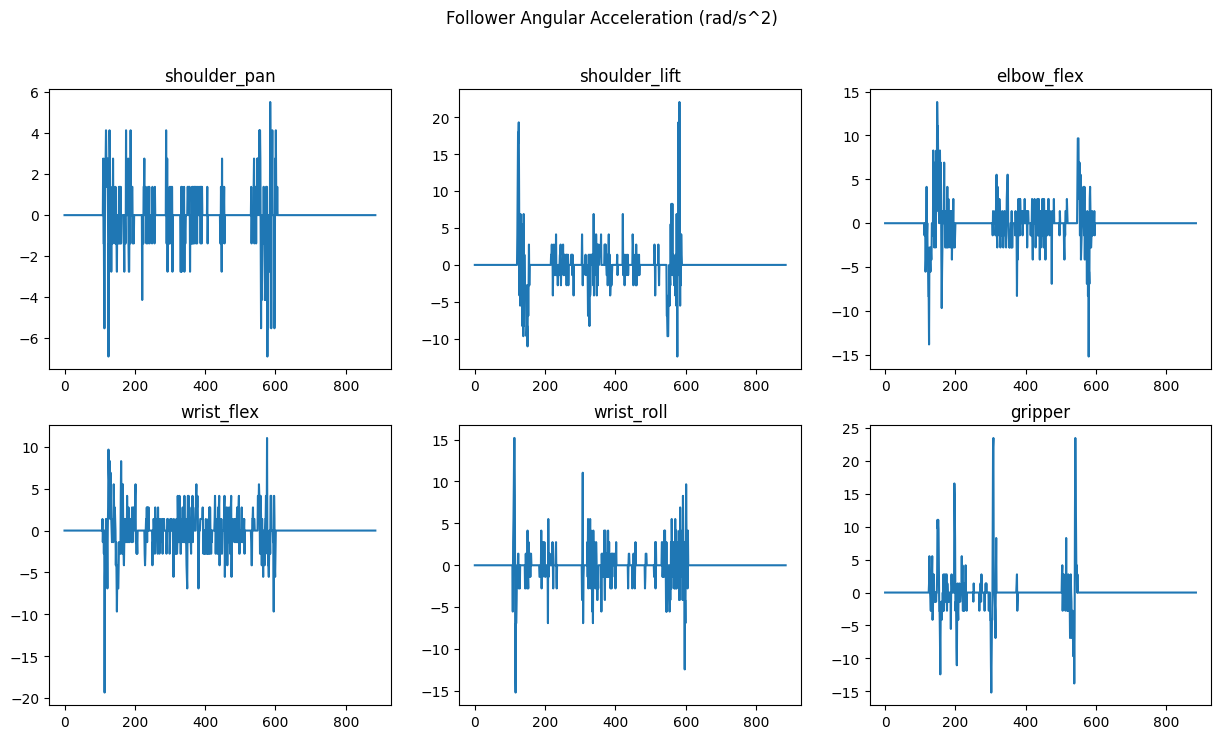

In [16]:
follower_acceleration = (q_dot[1:] - q_dot[:-1]) * ds_meta.fps

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for joint_id in range(dof):
    axes[joint_id].plot(frame_ids[:-2], follower_acceleration[:, joint_id], label='Follower')
    axes[joint_id].set_title(f'{joint_names[joint_id]}')

plt.suptitle(f"Follower Angular Acceleration (rad/s^2)")
plt.show()


## Gripper joint

The gripper joint connects the fixed jaw to the mobile jaw, allowing to open and close the gripper.

<center>
    <img src="../doc/LeaderArm.jpg" alt="Leader Arm" style="width:200px;"/>
</center>

Here's the sequence of steps in the gripper chart:

| Step | Description |
|-------------|------------------|
| 1 | Both the Leader and the Follower are closed at the beginning, laid down in the rest position. |
| 2 | The Leader opens the gripper. |
| 3 | The Leader closes the gripper. |
| 4 | When the Follower holds the ball, the grippers blocks half-way, while the Leader closes all the way. |
| 5 | The Leader opens the gripper. Once the Leader reaches the Follower closed position and passes it to open it, the follower releases the ball, placing it in the cup. |
| 6 | Both the Leader and the Follower are closed again until the end, like at the beginning. |


### Hold state

To identify the holding period, apply a threshold on the difference between the Leader & the Follower position.

gripper_diff = tensor([ 1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,  1.2197e-01,
         1.2197e-01,  1.2197e-01,  1

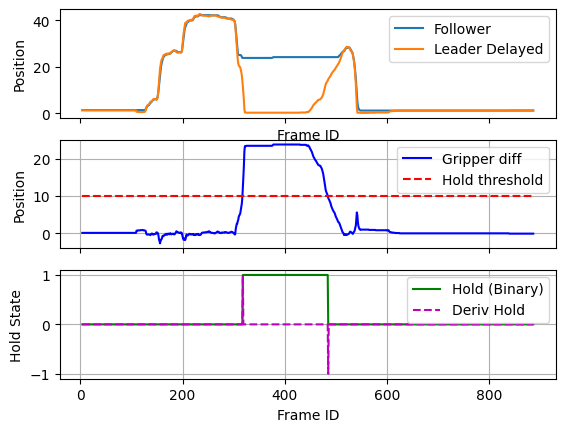

In [ ]:
gripper_id = 5

truncated_leader_gripper = truncated_leader[:, gripper_id]
truncated_follower_gripper = truncated_follower[:, gripper_id]

gripper_diff = truncated_follower_gripper-truncated_leader_gripper
diff_threshold = 10
gripper_threshold = torch.full_like(gripper_diff, fill_value=diff_threshold)

above_threshold = torch.where(gripper_diff > diff_threshold, 1, 0)

above_threshold_derivative = torch.diff(above_threshold, prepend=above_threshold[0:1])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.plot(truncated_frame_ids, truncated_follower_gripper, label='Follower')
ax1.plot(truncated_frame_ids, truncated_leader_gripper, label='Leader Delayed')
ax1.set_xlabel('Frame ID')
ax1.set_ylabel('Position')
ax1.legend()
plt.grid(True)

# --- Top Plot: Gripper Diff and Threshold ---
ax2.plot(truncated_frame_ids, gripper_diff, 'b-', label='Gripper diff')
ax2.plot(truncated_frame_ids, gripper_threshold, 'r--', label='Hold threshold')
ax2.set_ylabel('Position')
ax2.legend()
ax2.grid(True)

# --- Bottom Plot: Hold and Derivative Signals ---
ax3.plot(truncated_frame_ids, above_threshold, 'g-', label='Hold (Binary)')
ax3.plot(truncated_frame_ids, above_threshold_derivative, 'm--', label='Deriv Hold')
ax3.set_xlabel('Frame ID')
ax3.set_ylabel('Hold State')
ax3.legend()
ax3.grid(True)


In [18]:
sustained_frames = ds_meta.fps # at least 1 sec of holding 

counter = torch.full_like(above_threshold, fill_value=0)

frame = len(above_threshold) - 1 # last frame
counter[frame] = 1 if above_threshold[frame] == 1 else 0

hold_start_frames = []
hold_end_frames = []

for frame in range(frame-1, -1, -1): # for every fram from last to first
    if above_threshold[frame] == 1:
        counter[frame] = counter[frame+1] + 1
    else:
        if counter[frame+1] >= sustained_frames:
            hold_start_frames.append(frame+1)
            hold_end_frame = frame + counter[frame+1]
            hold_end_frame = hold_end_frame.item()
            hold_end_frames.append(hold_end_frame)

        counter[frame] = 0

frame = 0 # first frame
if counter[frame] >= sustained_frames:
    hold_start_frames.append(frame)
    hold_end_frame = frame + counter[frame] - 1
    hold_end_frame = hold_end_frame.item()
    hold_end_frames.append(hold_end_frame)

hold_start_frames, hold_end_frames

([314], [480])

The start and end frames of the holding period provide the pick and the place position respectively.

They identify the original positions of the ball and the cup.

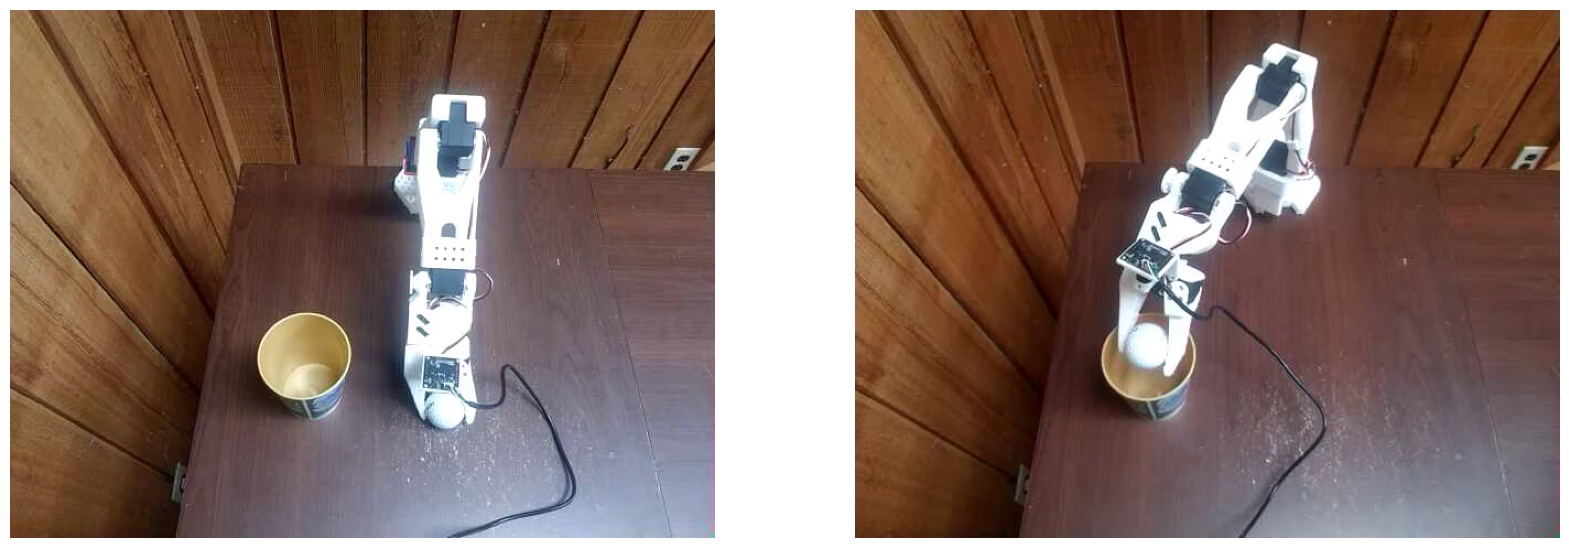

In [19]:
pick_frame_idx = hold_start_frames[0]
place_frame_idx = hold_end_frames[0]

camera = episode['observation.images.phone']

# Convert tensor to a 2D array of RGB pixels
# Channels x Width x Height -> Width x Height x Channels

def get_image(frame_idx):
    img = camera[frame_idx]
    img = img.data.numpy()
    img = img.transpose(1, 2, 0)
    img = (img * 255).astype("uint8")
    return img

pick_img = get_image(pick_frame_idx)
place_img = get_image(place_frame_idx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(pick_img)
ax1.set_axis_off()
ax2.imshow(place_img)
ax2.set_axis_off()